In [17]:
pip install folium


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [18]:
# pip install folium
# запустите, если у вас не работают карты

import pandas as pd
import numpy as np
import folium
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import warnings


In [19]:
features = pd.read_csv("/Users/artemshevchenko/Desktop/ВК/features.csv", delimiter=",")
test_data = pd.read_csv("/Users/artemshevchenko/Desktop/ВК/test.csv")
train_data = pd.read_csv('/Users/artemshevchenko/Desktop/ВК/train.csv')

features

,lat,lon,0,1,2,3,4,5,6,7,...,353,354,355,356,357,358,359,360,361,362
0,59.837100,30.262701,0.411159,0.360032,0.350883,0.476389,0.373542,0.399907,0.397579,0.486442,...,0.041906,0.045916,0.085368,0.093044,0.014491,0.004091,0.043260,0.045916,0.060025,0.071592
1,59.935705,30.274201,0.500628,0.458489,0.522933,0.538892,0.482807,0.497257,0.541007,0.482956,...,0.041262,0.054171,0.066940,0.057510,0.007990,0.017897,0.042617,0.054171,0.047068,0.044251
2,59.929714,30.419863,0.450037,0.413593,0.445300,0.490658,0.403224,0.448099,0.516285,0.526028,...,0.044056,0.052290,0.126482,0.116896,0.006771,0.007329,0.045406,0.052290,0.088934,0.089945
3,56.111227,40.356119,0.160964,0.146153,0.301632,0.196871,0.157927,0.130723,0.246422,0.385300,...,0.043072,0.051181,0.042962,0.030555,0.010293,0.002216,0.044425,0.051181,0.030208,0.023510
4,56.233351,43.872728,0.102522,0.073835,0.270109,0.129343,0.106780,0.082463,0.201381,0.372377,...,0.047839,0.048137,0.135698,0.163684,0.009615,0.003579,0.049185,0.048137,0.095414,0.125946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3696,55.491370,37.308973,0.603469,0.427283,0.616920,0.787331,0.585380,0.572505,0.414610,0.439459,...,0.040365,0.049803,0.115943,0.086169,0.003115,0.002045,0.041721,0.049803,0.081524,0.066302
3697,55.752230,52.410299,0.111785,0.105864,0.223382,0.120843,0.107082,0.094998,0.371929,0.296617,...,0.254405,0.220451,0.510766,0.568700,0.401002,0.182376,0.445025,0.417609,0.599474,0.731169
3698,59.959671,30.304035,0.439632,0.425653,0.368872,0.489872,0.389968,0.428121,0.510918,0.351653,...,0.037683,0.046643,0.048304,0.046775,0.013543,0.009374,0.039043,0.046643,0.033964,0.035991
3699,47.239728,39.761925,0.189145,0.216876,0.354758,0.177157,0.151277,0.190271,0.238387,0.298505,...,0.052133,0.047801,0.065017,0.084407,0.001219,0.004602,0.053472,0.047801,0.045716,0.064947


In [20]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371

    lat1_rad, lon1_rad = np.radians(lat1), np.radians(lon1)
    lat2_rad, lon2_rad = np.radians(lat2), np.radians(lon2)

    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    a = np.sin(dlat / 2) ** 2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))

    distance = R * c
    return distance

# Мотивация

В этом файле приведены две важнейшие функции для подбора генерации признаков. В одной из них (illustrare_num_clasters) я буду определять оптимальное число генерируемых признаков (основанных на дальности от больших городов - центров кластеров), необходимых для минимизации ошибки. В другой (itearte_through_correlation) - определять оптимальную границу возможной корреляции признаков для отбора независимых для эффективности и скорости обучения, без потери в MAE.

Подобранные здесь значения будут использоваться в основном решении в файле solution.ipynb

In [21]:
def illustrare_num_clasters(test_data, train_data, cluster_min, cluster_max, mae_values=[]):
    n_clusters_values = range(cluster_min, cluster_max)
    for n_clusters in n_clusters_values:
        X = features[['lat', 'lon']]

        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(X)

        features['cluster'] = kmeans.labels_

        cluster_centers = kmeans.cluster_centers_

        for i in range(n_clusters):
            cluster_lat, cluster_lon = cluster_centers[i]
        
        for i in range(n_clusters):
            cluster_lat, cluster_lon = cluster_centers[i]
            features[f'distance_to_cluster{i}'] = features.apply(lambda row: haversine(row['lat'], row['lon'], cluster_lat, cluster_lon), axis=1)   

        threshold_distance = 0.2
        distances = cdist(train_data[['lat', 'lon']], features[['lat', 'lon']], metric='euclidean')
        nearest_indices = np.argmin(distances, axis=1)
        nearest_distances = np.min(distances, axis=1)

        merged_data_train = train_data.copy()
        merged_data_train['nearest_index'] = nearest_indices
        merged_data_train['nearest_distance'] = nearest_distances
        merged_data_train = merged_data_train[merged_data_train['nearest_distance'] < threshold_distance]
        merged_data_train = pd.merge(merged_data_train, features, left_on='nearest_index', right_index=True)
        merged_data_train = merged_data_train.drop(['nearest_index', 'nearest_distance'], axis=1)

        threshold_distance = 0.4
        distances = cdist(test_data[['lat', 'lon']], features[['lat', 'lon']], metric='euclidean')
        nearest_indices = np.argmin(distances, axis=1)
        nearest_distances = np.min(distances, axis=1)

        merged_data_test = test_data.copy()
        merged_data_test['nearest_index'] = nearest_indices
        merged_data_test['nearest_distance'] = nearest_distances
        merged_data_test = merged_data_test[merged_data_test['nearest_distance'] < threshold_distance]
        merged_data_test = pd.merge(merged_data_test, features, left_on='nearest_index', right_index=True)
        merged_data_test = merged_data_test.drop(['nearest_index', 'nearest_distance'], axis=1)
        
        X = merged_data_train.drop(columns=['score'], axis=1)
        y = merged_data_train['score']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        model = RandomForestRegressor(random_state=42)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)

        mae = mean_absolute_error(y_test, predictions)
        mae_values.append(mae)

    plt.plot(n_clusters_values, mae_values, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title('MAE vs Number of Clusters')
    plt.grid(True)
    plt.show()


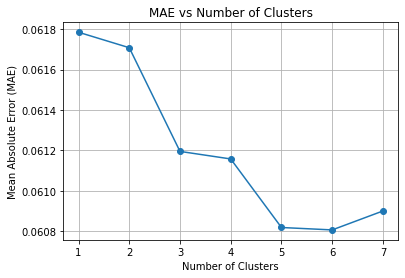

In [22]:
illustrare_num_clasters(test_data, train_data, 1, 8)

Локальный минимум в границах эффективности алгоритма по времени получилось, что 6 - оптимальное количество кластеров для генерации признаков.

In [27]:
def itearte_through_correlation(l_bound, h_bound, step=0.1):
    thresholds = np.arange(l_bound, h_bound + step, step, dtype=float)
    
    features = pd.read_csv("/Users/artemshevchenko/Desktop/ВК/features.csv", delimiter=",")
    test_data = pd.read_csv("/Users/artemshevchenko/Desktop/ВК/test.csv")
    train_data = pd.read_csv('/Users/artemshevchenko/Desktop/ВК/train.csv')
    
    features_copy = features.copy()
    test_data_copy = test_data.copy()
    train_data_copy = train_data.copy()
    
    corr_matrix = features_copy.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    
    mae_values = []
    for threshold in thresholds:
        features_copy = features.copy()
        
        to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
        features_copy.drop(columns=to_drop, inplace=True)

        first_columns = features_copy.columns[:2]
        other_columns = range(0, len(features_copy.columns) - 2)
        new_columns = list(first_columns) + list(other_columns)
        features_copy.columns = new_columns
        
        X = features_copy[['lat', 'lon']]
        
        n_clusters = 6
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(X)

        features_copy['cluster'] = kmeans.labels_
        cluster_centers = kmeans.cluster_centers_

        for i in range(n_clusters):
            cluster_lat, cluster_lon = cluster_centers[i]
            features_copy[f'distance_to_cluster{i}'] = features_copy.apply(lambda row: haversine(row['lat'], row['lon'], cluster_lat, cluster_lon), axis=1)  
            
        threshold_distance = 0.2
        distances = cdist(train_data_copy[['lat', 'lon']], features_copy[['lat', 'lon']], metric='euclidean')
        nearest_indices = np.argmin(distances, axis=1)
        nearest_distances = np.min(distances, axis=1)

        merged_data_train = train_data_copy.copy()
        merged_data_train['nearest_index'] = nearest_indices
        merged_data_train['nearest_distance'] = nearest_distances
        merged_data_train = merged_data_train[merged_data_train['nearest_distance'] < threshold_distance]
        merged_data_train = pd.merge(merged_data_train, features_copy, left_on='nearest_index', right_index=True)
        merged_data_train = merged_data_train.drop(['nearest_index', 'nearest_distance'], axis=1)

        threshold_distance = 0.4
        distances = cdist(test_data_copy[['lat', 'lon']], features_copy[['lat', 'lon']], metric='euclidean')
        nearest_indices = np.argmin(distances, axis=1)
        nearest_distances = np.min(distances, axis=1)

        merged_data_test = test_data_copy.copy()
        merged_data_test['nearest_index'] = nearest_indices
        merged_data_test['nearest_distance'] = nearest_distances
        merged_data_test = merged_data_test[merged_data_test['nearest_distance'] < threshold_distance]
        merged_data_test = pd.merge(merged_data_test, features_copy, left_on='nearest_index', right_index=True)
        merged_data_test = merged_data_test.drop(['nearest_index', 'nearest_distance'], axis=1)
        
        X = merged_data_train.drop(columns=['score'], axis=1)
        y = merged_data_train['score']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        model = RandomForestRegressor(random_state=42)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)

        mae = mean_absolute_error(y_test, predictions)
        mae_values.append(mae)
    
    plt.plot(thresholds, mae_values, marker='o')
    plt.xlabel('Correlation higher bound')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title('MAE vs Correlation')
    plt.grid(True)
    plt.show()


/var/folders/cc/z_7321hx7vl1_pj490x10fhc0000gn/T/ipykernel_35060/523215587.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
/Users/artemshevchenko/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/artemshevchenko/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes

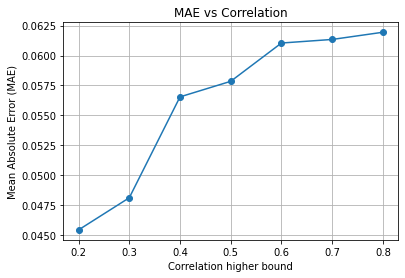

In [28]:
itearte_through_correlation(0.2, 0.8, 0.1)

Создалась ситуация, в которой, по причинам специфика данных, наша функция монотонно возрастает на выбранном промежутке для данного значения n_clusters. Для профилактики переобучения и соблюдения баланса между использованием имеющихся данных, эффективностью и точностью, возьмём границу в виде 0.55